# Import libraries

In [1]:
# general
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
# encoders
from category_encoders.target_encoder import TargetEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
# custom classes
from preprocessing import Merger, Imputer, Cleaner
# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [2]:
store_data = pd.read_csv("./data/store.csv")
sales_data = pd.read_csv("./data/train.csv")
holdout_data = pd.read_csv("./data/holdout.csv")

/Users/corstiaen/opt/anaconda3/envs/minicomp_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We will use the holdout data as our test set.

# Preprocessing of data

## Merging tables

Our store information is separate from our sales information. In our Merger object we perform multiple operations:
* Drop sales data where sales is NaN or 0.
* Drop the customers column because of its direct relation to sales and its unknown value when predicting the future.
* Combine sales and store data into a single table by joining on the store ID.
* All stores without and ID, i.e., the NaNs, are given the label 0. This label was not in use as a store ID.

In [3]:
mrg = Merger()
mrg.merge(sales_data, store_data)
merged_data = mrg.merged_data

/Users/corstiaen/opt/anaconda3/envs/minicomp_env/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
mrg = Merger()
mrg.merge(holdout_data, store_data)
merged_holdout_data = mrg.merged_data

In [5]:
print(f"We have {len(merged_data)} samples to work with.")
merged_data.sample(5)

We have 512956 samples to work with.


,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
54329,2013-03-01,211,5.0,13571.0,1.0,0.0,0,0.0,a,c,350.0,11.0,2006.0,0.0,NaN,NaN,NaN
34233,2013-02-07,633,4.0,5455.0,1.0,1.0,0,0.0,d,a,11640.0,4.0,2005.0,1.0,22.0,2011.0,"Jan,Apr,Jul,Oct"
338252,2014-01-13,804,1.0,3797.0,1.0,0.0,0,0.0,c,c,2100.0,NaN,NaN,1.0,1.0,2013.0,"Jan,Apr,Jul,Oct"
206957,2013-08-20,400,2.0,6334.0,1.0,0.0,0,1.0,a,a,70.0,11.0,2004.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
345184,2014-01-21,27,2.0,11751.0,1.0,1.0,0,0.0,a,a,60.0,1.0,2005.0,1.0,5.0,2011.0,"Jan,Apr,Jul,Oct"


In [6]:
print(f"We have {len(merged_holdout_data)} samples in out test set.")

We have 315540 samples in out test set.


In [7]:
duped_mask = merged_data.duplicated()
duplicated_data = merged_data.loc[duped_mask, :]

print(f"There are {len(duplicated_data)} duplicated values in our dataset.")
print(f"This is a low number compared to the {len(merged_data)} samples in our dataset.")
print("These duplicates are not necessarily 'true' because the store ID is not known.")
print("Therefore these duplicates may actually be two shops having the exact same sales on a single day.")
print("Because of this uncertainty we are keeping the duplicates in our dataset.")

There are 30 duplicated values in our dataset.
This is a low number compared to the 512956 samples in our dataset.
These duplicates are not necessarily 'true' because the store ID is not known.
Therefore these duplicates may actually be two shops having the exact same sales on a single day.
Because of this uncertainty we are keeping the duplicates in our dataset.


## Splitting data

Because we are using the holdout data as our test data, we have no need to split or data further. We are dealing with time-series data and our test data follows our train chronologically.

In [8]:
print(f"The last day in our train data is {merged_data['Date'].max()}")

The last day in our train data is 2014-07-31


In [9]:
print(f"The first day in our test data is {merged_holdout_data['Date'].min()}")

The first day in our test data is 2014-08-01


We do need to split our feature and target data.

In [10]:
X_train = merged_data.loc[:, ~merged_data.columns.isin(["Sales"])]
y_train = merged_data.loc[:, "Sales"]

X_test = merged_holdout_data.loc[:, ~merged_holdout_data.columns.isin(["Sales"])]
y_test = merged_holdout_data.loc[:, "Sales"]

Splitting results.

In [11]:
print(f"Our train set has {len(X_train)} samples")
print(f"Our test set has {len(X_test)} samples")

Our train set has 512956 samples
Our test set has 315540 samples


## Data profiling

The cell below creates an html file that describes the characteristics of the features of our dataset. The resulting profile report can be opened by following the link below:

**[Rossmann profile report](files/rossmann_profile_report.html)**

In [12]:
profile = ProfileReport(X_train)
profile.to_file(output_file="rossmann_profile_report.html")

## Feature engineering

For each feature we applied the following changes:

**Date**
* Split feature into four features: year, month, day of week. A week-feature would have high correlation with a month-feature and is therefore not desired.
* Encode month, week, and day of week with sine+cosine for circularity
* Drop the original feature

**DayOfWeek**
* Drop feature, will be replaced with values derived from Date

**Store**
* Applying target encoding
* Considered frequency encoding, but target encoding seemed good enough.

**Open**
* Two values available: 1 (True) and NaN. Therefore using zero imputation.
* If feature turns out to be unimportant (likely with ~3% NaNs), drop feature after first tests

**Promo**
* Mode imputing ~3% of NaNs

**StateHoliday**
* Four categories
* Category 0.0 needs to be changed to "0"
* Mode imputing ~3% of NaNs
* Apply ordinal encoding because number of stores open is in goes in descending order: 0>a>b>c. This likely reflects overall store opening in the nation.

**SchoolHoliday**
* Mode imputing ~3% of NaNs

**StoreType**
* Mode imputing ~3%
* Ordinal encoding because 4 models, a-d, may very well relate to store size, e.g., large shopping mall store vs. small train station store.

**Assortment**
* Mode imputing ~3%
* Apply ordinal encoding because assortment is an ordinate: a = basic, b = extra, c = extended    
    
**CompetitionDistance**
* Applying median imputation to ~3% missing values

**CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear**
* Merge and create new feature, giving temporal distance in days from sales date, and drop the original features
* Set negative days, i.e., days before competition opened, to 0
* First imputation: set NaNs to -1

**Promo2**
* Mode imputing ~3%
* All 1s (True) also have other information on Promo2
* When there is a NaN there is no information on a possible promotion. Though a promotion is not likely and 0 imputation could be good, we still choose mode imputation due to a lack of information.

**Promo2SinceWeek** and **Promo2SinceYear**
* Merge and create new feature, giving temporal distance in days from sales date, and drop the original features
* Set negative days, i.e., days before Promo2 started, to 0
* First imputation: set NaNs to -1

**PromoInterval**
* Mode imputed
* Apply one-hot encoding

## Impute missing values

Following the considerations and strategies above, we first impute missing values.

In [13]:
imp = Imputer()
imp.define_imputers()
imp.fit(X_train)
X_train_transf = imp.transform_reconstruct(X_train)
X_test_transf = imp.transform_reconstruct(X_test)

## Clean data

With most values imputed, we follow the above considerations and strategies for further cleaning

In [14]:
clnr = Cleaner()
clnr.clean(X_train_transf)
X_train_clean = clnr.data

clnr = Cleaner()
clnr.clean(X_test_transf)
X_test_clean = clnr.data

## Cleaned data

After the above steps, our data looks as follows.

In [15]:
X_train_clean.sample(7)

,Store,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,Year,Month_sin,Month_cos,Weekday_sin,Weekday_cos,SalesCompetitionLag,Promo2Lag
141218,470,1.0,0.0,0,0.0,a,c,50.0,0.0,"Jan,Apr,Jul,Oct",2013,1.224647e-16,-1.000000,0.000000,1.000000,-1.0,-1.0
84444,468,1.0,0.0,0,1.0,c,c,5260.0,0.0,"Jan,Apr,Jul,Oct",2013,8.660254e-01,-0.500000,0.068802,0.997630,216.0,-1.0
323206,624,1.0,0.0,0,1.0,a,c,6920.0,0.0,"Jan,Apr,Jul,Oct",2013,-2.449294e-16,1.000000,0.017213,0.999852,845.0,-1.0
272980,622,1.0,0.0,0,0.0,a,c,2320.0,0.0,"Jan,Apr,Jul,Oct",2013,-8.660254e-01,0.500000,0.034422,0.999407,-1.0,-1.0
16142,0,1.0,0.0,0,0.0,a,a,2320.0,1.0,"Jan,Apr,Jul,Oct",2013,5.000000e-01,0.866025,0.068802,0.997630,-1.0,-1.0
181492,253,1.0,0.0,0,1.0,a,c,250.0,1.0,"Feb,May,Aug,Nov",2013,-5.000000e-01,-0.866025,0.017213,0.999852,-1.0,170.0
38130,211,0.0,0.0,0,0.0,a,c,350.0,0.0,"Jan,Apr,Jul,Oct",2013,8.660254e-01,0.500000,0.017213,0.999852,2295.0,-1.0


## Correlation of features before modeling

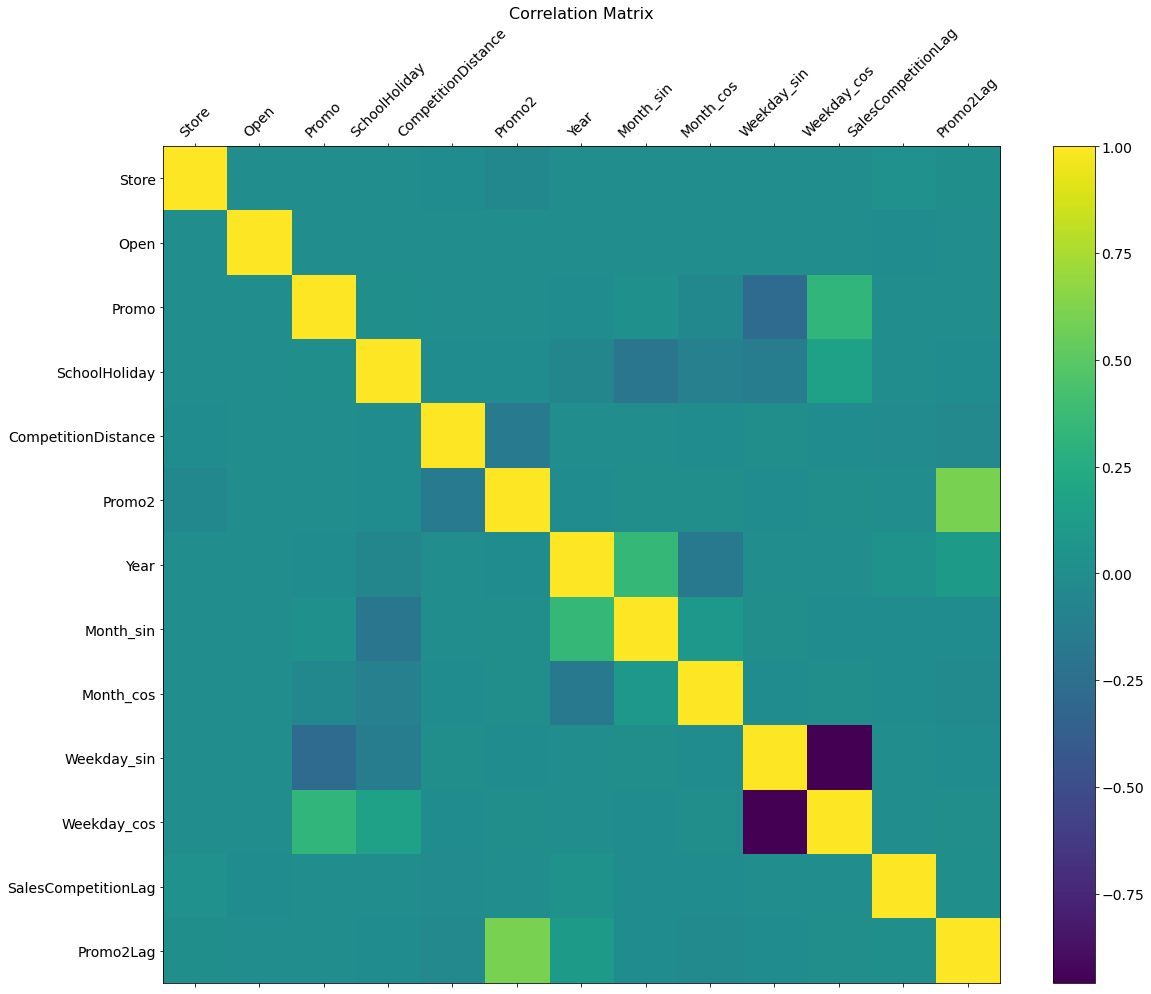

In [16]:
f = plt.figure(figsize=(19, 15))

plt.matshow(X_train_clean.corr(), fignum=f.number)

plt.xticks(
    range(X_train_clean.select_dtypes(['number']).shape[1]),
    X_train_clean.select_dtypes(['number']).columns,
    fontsize=14,
    rotation=45)
plt.yticks(
    range(X_train_clean.select_dtypes(['number']).shape[1]),
    X_train_clean.select_dtypes(['number']).columns,
    fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.title('Correlation Matrix', fontsize=16);

# Modeling

## Performance metric

The function below calculates our model performance.

In [17]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.values.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

## Baseline performance
Baseline performance is based on the average sales per store.

In [18]:
mean_df = merged_holdout_data.groupby('Store')['Sales'].mean()
avg_sales = mean_df.reset_index()
avg_sales_by_store = X_test_clean.merge(avg_sales, how='left', on='Store')
base_score = metric(avg_sales_by_store.loc[:, 'Sales'].values, y_test)
print(f"Our baseline RMSPE is {base_score}.")

Our baseline RMSPE is 43.83318407645237.


## Begin pipeline

We start with building a base-pipeline on which we can build our models. This base pipeline takes care of data encoding.

In [19]:
def create_pipeline():
    pipe = Pipeline([
        ("target_encoder", TargetEncoder(cols="Store")),
        ("ordinal_encoder", OrdinalEncoder(cols=["StateHoliday", "StoreType", "Assortment"])),
        ("one_hot_encoder", OneHotEncoder(cols=["PromoInterval"])),
    ], verbose=True)
    return pipe

## Random forest

In a large parameter space of n_estimators, max_depth, and min_samples_split we found the following train and test scores for a subset of our training data.

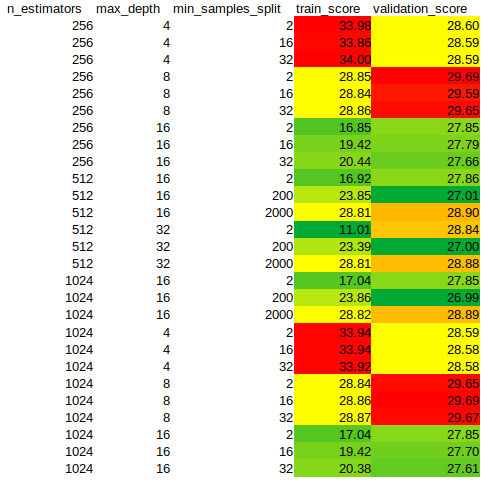

On the full dataset, we find the following hyperparameter space.

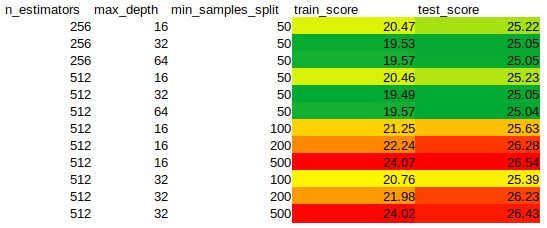

To speed up running of this notebook we removed the full parameter space exploration. We focus on the following hyperparameters:

    n_estimators = [256, 512]
    max_depth = [16, 32, 64]
    min_samples_split = [32, 50, 100]
    
We recommen not running the cell below, and skip to the section "Best model."

In [20]:
n_estimators = [256, 512]
max_depth = [16, 32, 64]
min_samples_split = [32, 50, 100]

params = pd.DataFrame()
best_test_score = np.inf
for ne in n_estimators:
    for md in max_depth:
        for mss in min_samples_split:
            # Create random forest
            rfr = RandomForestRegressor(
                n_estimators=ne,
                max_depth=md,
                min_samples_split=mss,
                n_jobs=-1,
                verbose=1,
            )

            # Create pipeline and fit model
            pipe = create_pipeline()
            pipe.steps.append(['rfr', rfr])
            pipe.fit(X_train_clean, y_train)

            # Predictions
            y_pred_train = pipe.predict(X_train_clean)
            y_pred_test = pipe.predict(X_test_clean)
            train_score = metric(y_pred_train, y_train)
            test_score = metric(y_pred_test, y_test)

            # Save model scores
            params = params.append(pd.Series({
                "n_estimators": ne,
                "max_depth": md,
                "min_samples_split": mss,
                "train_score": train_score,
                "test_score": test_score,
            }), ignore_index=True)
            
            # Save best model
            if test_score < best_test_score:
                best_model = pipe


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.3min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 2.3min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    2.2s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.2s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.2min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 2.2min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    2.1s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.2s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.2min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 2.2min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    2.0s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.2s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.7min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 2.7min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    3.2s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.2s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.5min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 2.5min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    2.2s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.7min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 2.7min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    2.2s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  3.0min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 3.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    3.4s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.2s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.6min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 2.6min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    2.9s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  2.4min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 2.4min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 256 out of 256 | elapsed:    2.1s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  4.9min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 4.9min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    7.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    5.3s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.6s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  4.6min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 4.6min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:   10.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    5.1s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.2s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  6.0min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 6.0min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    6.4s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.2s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  6.9min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 6.9min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   11.8s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    7.3s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.2s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  6.7min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 6.7min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    4.4s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  3.8min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 3.8min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    3.6s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.5s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  5.5min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 5.5min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:   11.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    7.0s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.2s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  4.9min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 4.9min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    4.4s finished


[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.3s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  5.2min finished


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 5.2min


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 512 out of 512 | elapsed:    3.9s finished


Train and test scores:

In [21]:
params

,n_estimators,max_depth,min_samples_split,train_score,test_score
0,256.0,16.0,32.0,19.964764,25.536484
1,256.0,16.0,50.0,20.496920,25.253304
2,256.0,16.0,100.0,21.215599,25.572251
3,256.0,32.0,32.0,18.682230,25.316945
4,256.0,32.0,50.0,19.524072,25.085698
5,256.0,32.0,100.0,20.748013,25.511716
6,256.0,64.0,32.0,18.596334,25.359010
7,256.0,64.0,50.0,19.555860,25.041480
8,256.0,64.0,100.0,20.765268,25.496036
9,512.0,16.0,32.0,19.924029,25.553654


## Best model

The random forest regressor with the best performance in our parameter space is described as follows:

In [22]:
n_estimators = 512
max_depth = 32
min_samples_split = 50

We now train the best model using both the train and test data.

In [23]:
X_all = pd.concat([X_train, X_test], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)

In [29]:
imp = Imputer()
imp.define_imputers()
imp.fit(X_all)
X_all_transf = imp.transform_reconstruct(X_all)

clnr = Cleaner()
clnr.clean(X_all_transf)
X_all_clean = clnr.data

In [30]:
rfr = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    n_jobs=-1,
    verbose=1,
)

model = create_pipeline()

model.steps.append(['rfr', rfr])
model.fit(X_all_clean, y_all)

[Pipeline] .... (step 1 of 4) Processing target_encoder, total=   0.4s
[Pipeline] ... (step 2 of 4) Processing ordinal_encoder, total=   0.1s
[Pipeline] ... (step 3 of 4) Processing one_hot_encoder, total=   0.7s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.1min


[Pipeline] ............... (step 4 of 4) Processing rfr, total= 7.1min


[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  7.1min finished


Pipeline(steps=[('target_encoder', TargetEncoder(cols=['Store'])),
                ('ordinal_encoder',
                 OrdinalEncoder(cols=['StateHoliday', 'StoreType',
                                      'Assortment'],
                                mapping=[{'col': 'StateHoliday',
                                          'data_type': CategoricalDtype(categories=['0', 'a', 'b', 'c'], ordered=False),
                                          'mapping': a      1
0      2
b      3
c      4
NaN   -2
dtype: int64},
                                         {'col': 'StoreType',
                                          'data_type': CategoricalDtype(categories=['a',...rdered=False),
                                          'mapping': b      1
a      2
d      3
c      4
NaN   -2
dtype: int64},
                                         {'col': 'Assortment',
                                          'data_type': CategoricalDtype(categories=['a', 'b', 'c'], ordered=False),
                  

We can see the feature importances for this model as follows.

               features    values
0                 Store  0.676118
2                 Promo  0.154651
14            Month_cos  0.031948
15          Weekday_sin  0.030204
16          Weekday_cos  0.029333
7   CompetitionDistance  0.018184
17  SalesCompetitionLag  0.015106
18            Promo2Lag  0.008783
5             StoreType  0.008040
4         SchoolHoliday  0.006586
13            Month_sin  0.006392
12                 Year  0.006074
6            Assortment  0.003442
3          StateHoliday  0.001435
10      PromoInterval_2  0.000900
8                Promo2  0.000871
11      PromoInterval_3  0.000768
9       PromoInterval_1  0.000756
1                  Open  0.000408


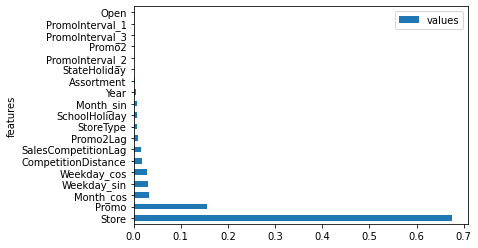

In [31]:
importances = pd.DataFrame({
    "features": model.steps[3][1].feature_names_in_,
    "values": model.steps[3][1].feature_importances_,
})

print(importances.sort_values(by="values", ascending=False))

importances.set_index("features").sort_values(by="values", ascending=False).plot.barh()
plt.show()

# Evaluation

Final evaluation of our model's performance.

First specify the evaluation set.

In [34]:
eval_filename = ""

Then go through each preprocessing step, make predictions, and evaluate performance.

In [ ]:
# Load
unseen_data = pd.read_csv(eval_filename)
    
# Merge
mrg = Merger()
mrg.merge(unseen_data, store_data)
merged_unseen_data = mrg.merged_data

# Split
X_eval = merged_unseen_data.loc[:, ~merged_unseen_data.columns.isin(["Sales"])]
y_eval = merged_unseen_data.loc[:, "Sales"]

# Impute
imp.define_imputers()
imp.fit(X_all)
X_eval_transf = imp.transform_reconstruct(X_eval)

# Clean
clnr = Cleaner()
clnr.clean(X_eval_transf)
X_eval_clean = clnr.data

# Scoring
y_pred_eval = best_model.predict(X_eval_clean)
eval_score = metric(y_pred_eval, y_eval)
print(f"Our model scores an RMSPE of {eval_score}.")